# One step univariate model - ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA times series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model on a test dataset


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import sys
sys.path.append('..')
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.tools.plotting import autocorrelation_plot
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Set for demo purposes (shorter run)
demo = False

Load the data from csv into a Pandas dataframe

In [3]:
energy = load_data('../data')[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


Plot all available load data (January 2012 to Dec 2014)

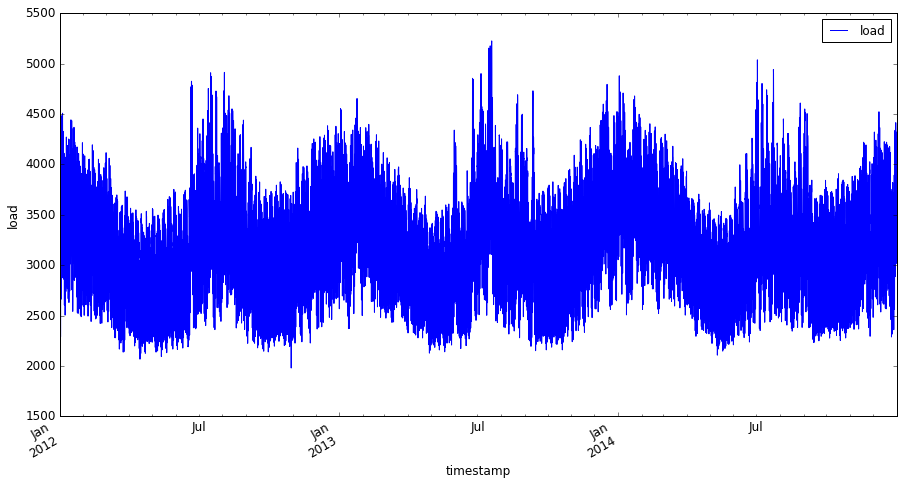

In [4]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Plot first week of July 2014

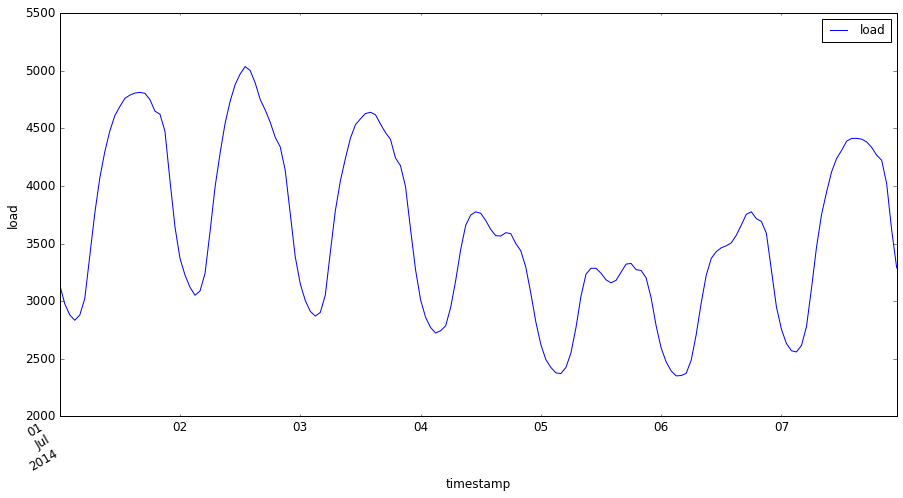

In [5]:
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Create training and testing data sets

We separate our dataset into train and test sets. We train the model on the train set. After the model has finished training, we evaluate the model on the test set. We must ensure that the test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st September 2014 to 31st October to training set (2 months) and the period 1st November 2014 to 31st December 2014 to the test set (2 months). Since this is daily consumption of energy, there is a strong seasonal pattern, but the consumption is most similar to the consumption in the recent days. Therefore, using a relatively small window of time for training the data should be sufficient.

In [6]:
train_start_dt = '2014-10-01 00:00:00'

if(not demo):
    test_start_dt = '2014-11-01 00:00:00'
else: 
    test_start_dt = '2014-12-30 00:00:00'
    

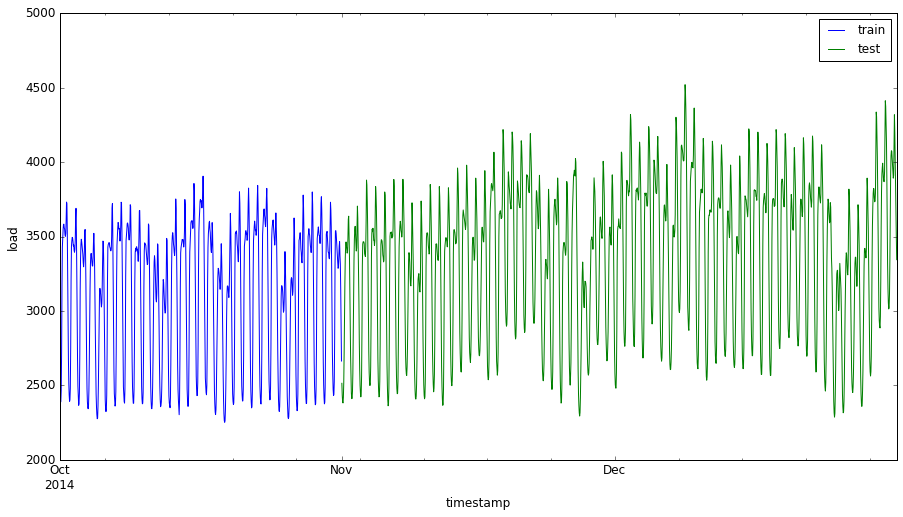

In [7]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Data preparation


Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)

Create training set containing only the model features

In [8]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (744, 1)
Test data shape:  (1464, 1)


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [9]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-10-01 00:00:00,0.15
2014-10-01 01:00:00,0.11
2014-10-01 02:00:00,0.08
2014-10-01 03:00:00,0.08
2014-10-01 04:00:00,0.13
2014-10-01 05:00:00,0.28
2014-10-01 06:00:00,0.56
2014-10-01 07:00:00,0.71
2014-10-01 08:00:00,0.75
2014-10-01 09:00:00,0.78


Original vs scaled data:

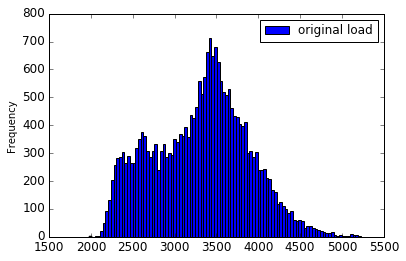

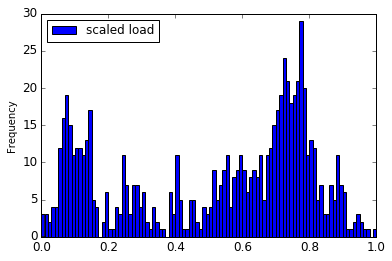

In [10]:
energy[energy.index < train_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Let's also scale the test data

In [11]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.11
2014-11-01 02:00:00,0.08
2014-11-01 03:00:00,0.08
2014-11-01 04:00:00,0.10


## Implement ARIMA method

An ARIMA, which stands for **A**uto**R**egressive **I**ntegrated **M**oving **A**verage, model can be created using the statsmodels library. In the next section, we perform the following steps:
1. Define the model by calling SARIMAX() and passing in the model parameters: p, d, and q parameters, and P, D, and Q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the forecast() function and specifying the number of steps (horizon) which to forecast

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:
- **p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. 
- **d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. 
- **q** is the parameter associated with the moving average part of the model.

If our model has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P, D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.

In [12]:
# Specify the number of steps to forecast ahead
HORIZON = 3 if demo else 24

Let’s look at an autocorrelation plot of the time series. The example below plots the autocorrelation for 48 lags in the time series.

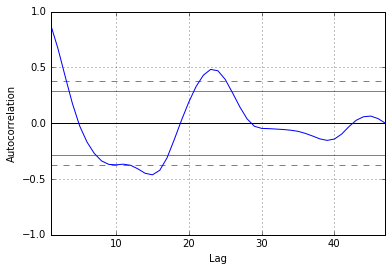

In [13]:
autocorrelation_plot(train[1:48])
plt.show()

We can see that there is a significant positive correlation with the first 4 or 5 lags. That may be a good starting point for the AR parameter (p) of the model.

The plot of energy load over time (see above) shows that the time series is not stationary due to its seasonality (daily peaks and also peaks in August and February due to the increased energy usage). This suggests the a certain degree of differencing the data might be necessary. 

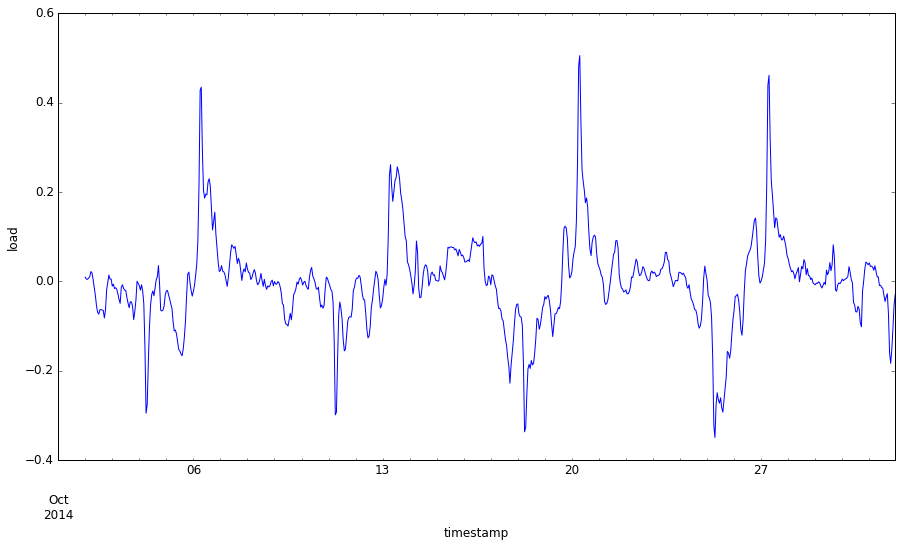

In [14]:
train['load'].diff(periods=24).plot(y='load', figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Even after differencing the data by 24 hours (the seasonal frequency), we still see a seasonal trend in the data. 

Selecting the best parameters for an Arima model can be challenging - somewhat subjective and time intesive, so we'll leave it as an exercise to the user. We used an **auto_arima()** function to search a provided space of parameters for the best model.

In [15]:
# Model search takes a while, so don't run it during the demo
auto_tune = False

if (auto_tune):
    auto_model = auto_arima(train, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())

In [16]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               load   No. Observations:                  744
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                1630.982
Date:                            Fri, 28 Sep 2018   AIC                          -3249.965
Time:                                    20:31:42   BIC                          -3222.498
Sample:                                10-01-2014   HQIC                         -3239.360
                                     - 10-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7789      0.021     37.993      0.000       0.739       0.819
ar.L2         -0.5345      0.041   

Next we display the distribution of residuals. A zero mean in the residuals may indicate that there is no bias in the prediction. 

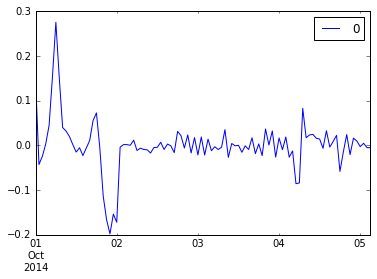

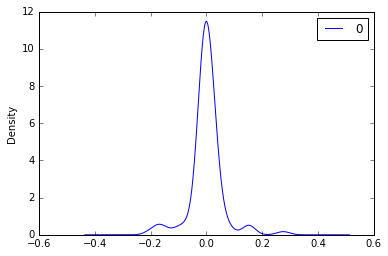

           0
count 100.00
mean    0.00
std     0.06
min    -0.20
25%    -0.01
50%    -0.00
75%     0.02
max     0.28


In [17]:
# plot residual errors
residuals = pd.DataFrame(results.resid[0:100])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Evaluate the model

We will perform the so-called **walk forward validation**. In practice, time series models are re-trained each time a new data becomes available. This allows the model to make the best forecast at each time step. 

Starting at the beginning of the time series, we train the model on the train data set. Then we make a prediction on the next time step. The prediction is then evaluated against the known value. The training set is then expanded to include the known value and the process is repeated. (Note that we keep the training set window fixed, for more efficient training, so every time we add a new observation to the training set, we remove the observation from the beginning of the set.)

This process provides a more robust estimation of how the model will perform in practice. However, it comes at the computation cost of creating so many models. This is acceptable if the data is small or if the model is simple, but could be an issue at scale. 

Walk-forward validation is the gold standard of time series model evaluation and is recommended for your own projects.

Create a test data point for each HORIZON step.

In [18]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3,load+4,load+5,load+6,load+7,load+8,load+9,...,load+14,load+15,load+16,load+17,load+18,load+19,load+20,load+21,load+22,load+23
2014-11-01 00:00:00,0.16,0.11,0.08,0.08,0.10,0.16,0.28,0.43,0.57,0.67,...,0.69,0.70,0.75,0.82,0.84,0.76,0.68,0.56,0.41,0.27
2014-11-01 01:00:00,0.11,0.08,0.08,0.10,0.16,0.28,0.43,0.57,0.67,0.72,...,0.70,0.75,0.82,0.84,0.76,0.68,0.56,0.41,0.27,0.19
2014-11-01 02:00:00,0.08,0.08,0.10,0.16,0.28,0.43,0.57,0.67,0.72,0.73,...,0.75,0.82,0.84,0.76,0.68,0.56,0.41,0.27,0.19,0.12
2014-11-01 03:00:00,0.08,0.10,0.16,0.28,0.43,0.57,0.67,0.72,0.73,0.72,...,0.82,0.84,0.76,0.68,0.56,0.41,0.27,0.19,0.12,0.10
2014-11-01 04:00:00,0.10,0.16,0.28,0.43,0.57,0.67,0.72,0.73,0.72,0.70,...,0.84,0.76,0.68,0.56,0.41,0.27,0.19,0.12,0.10,0.10


Make predictions on the test data

In [19]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(t+1, '. Predicting time step: ', test_ts.index[t])
    # print(t+1, ': predicted =', yhat, 'expected =', obs)

1 . Predicting time step:  2014-11-01 00:00:00
2 . Predicting time step:  2014-11-01 01:00:00
3 . Predicting time step:  2014-11-01 02:00:00
4 . Predicting time step:  2014-11-01 03:00:00
5 . Predicting time step:  2014-11-01 04:00:00
6 . Predicting time step:  2014-11-01 05:00:00
7 . Predicting time step:  2014-11-01 06:00:00
8 . Predicting time step:  2014-11-01 07:00:00
9 . Predicting time step:  2014-11-01 08:00:00
10 . Predicting time step:  2014-11-01 09:00:00
11 . Predicting time step:  2014-11-01 10:00:00
12 . Predicting time step:  2014-11-01 11:00:00
13 . Predicting time step:  2014-11-01 12:00:00
14 . Predicting time step:  2014-11-01 13:00:00
15 . Predicting time step:  2014-11-01 14:00:00
16 . Predicting time step:  2014-11-01 15:00:00
17 . Predicting time step:  2014-11-01 16:00:00
18 . Predicting time step:  2014-11-01 17:00:00
19 . Predicting time step:  2014-11-01 18:00:00
20 . Predicting time step:  2014-11-01 19:00:00
21 . Predicting time step:  2014-11-01 20:00:00
2

171 . Predicting time step:  2014-11-08 02:00:00
172 . Predicting time step:  2014-11-08 03:00:00
173 . Predicting time step:  2014-11-08 04:00:00
174 . Predicting time step:  2014-11-08 05:00:00
175 . Predicting time step:  2014-11-08 06:00:00
176 . Predicting time step:  2014-11-08 07:00:00
177 . Predicting time step:  2014-11-08 08:00:00
178 . Predicting time step:  2014-11-08 09:00:00
179 . Predicting time step:  2014-11-08 10:00:00
180 . Predicting time step:  2014-11-08 11:00:00
181 . Predicting time step:  2014-11-08 12:00:00
182 . Predicting time step:  2014-11-08 13:00:00
183 . Predicting time step:  2014-11-08 14:00:00
184 . Predicting time step:  2014-11-08 15:00:00
185 . Predicting time step:  2014-11-08 16:00:00
186 . Predicting time step:  2014-11-08 17:00:00
187 . Predicting time step:  2014-11-08 18:00:00
188 . Predicting time step:  2014-11-08 19:00:00
189 . Predicting time step:  2014-11-08 20:00:00
190 . Predicting time step:  2014-11-08 21:00:00
191 . Predicting tim

339 . Predicting time step:  2014-11-15 02:00:00
340 . Predicting time step:  2014-11-15 03:00:00
341 . Predicting time step:  2014-11-15 04:00:00
342 . Predicting time step:  2014-11-15 05:00:00
343 . Predicting time step:  2014-11-15 06:00:00
344 . Predicting time step:  2014-11-15 07:00:00
345 . Predicting time step:  2014-11-15 08:00:00
346 . Predicting time step:  2014-11-15 09:00:00
347 . Predicting time step:  2014-11-15 10:00:00
348 . Predicting time step:  2014-11-15 11:00:00
349 . Predicting time step:  2014-11-15 12:00:00
350 . Predicting time step:  2014-11-15 13:00:00
351 . Predicting time step:  2014-11-15 14:00:00
352 . Predicting time step:  2014-11-15 15:00:00
353 . Predicting time step:  2014-11-15 16:00:00
354 . Predicting time step:  2014-11-15 17:00:00
355 . Predicting time step:  2014-11-15 18:00:00
356 . Predicting time step:  2014-11-15 19:00:00
357 . Predicting time step:  2014-11-15 20:00:00
358 . Predicting time step:  2014-11-15 21:00:00
359 . Predicting tim

507 . Predicting time step:  2014-11-22 02:00:00
508 . Predicting time step:  2014-11-22 03:00:00
509 . Predicting time step:  2014-11-22 04:00:00
510 . Predicting time step:  2014-11-22 05:00:00
511 . Predicting time step:  2014-11-22 06:00:00
512 . Predicting time step:  2014-11-22 07:00:00
513 . Predicting time step:  2014-11-22 08:00:00
514 . Predicting time step:  2014-11-22 09:00:00
515 . Predicting time step:  2014-11-22 10:00:00
516 . Predicting time step:  2014-11-22 11:00:00
517 . Predicting time step:  2014-11-22 12:00:00
518 . Predicting time step:  2014-11-22 13:00:00
519 . Predicting time step:  2014-11-22 14:00:00
520 . Predicting time step:  2014-11-22 15:00:00
521 . Predicting time step:  2014-11-22 16:00:00
522 . Predicting time step:  2014-11-22 17:00:00
523 . Predicting time step:  2014-11-22 18:00:00
524 . Predicting time step:  2014-11-22 19:00:00
525 . Predicting time step:  2014-11-22 20:00:00
526 . Predicting time step:  2014-11-22 21:00:00
527 . Predicting tim

675 . Predicting time step:  2014-11-29 02:00:00
676 . Predicting time step:  2014-11-29 03:00:00
677 . Predicting time step:  2014-11-29 04:00:00
678 . Predicting time step:  2014-11-29 05:00:00
679 . Predicting time step:  2014-11-29 06:00:00
680 . Predicting time step:  2014-11-29 07:00:00
681 . Predicting time step:  2014-11-29 08:00:00
682 . Predicting time step:  2014-11-29 09:00:00
683 . Predicting time step:  2014-11-29 10:00:00
684 . Predicting time step:  2014-11-29 11:00:00
685 . Predicting time step:  2014-11-29 12:00:00
686 . Predicting time step:  2014-11-29 13:00:00
687 . Predicting time step:  2014-11-29 14:00:00
688 . Predicting time step:  2014-11-29 15:00:00
689 . Predicting time step:  2014-11-29 16:00:00
690 . Predicting time step:  2014-11-29 17:00:00
691 . Predicting time step:  2014-11-29 18:00:00
692 . Predicting time step:  2014-11-29 19:00:00
693 . Predicting time step:  2014-11-29 20:00:00
694 . Predicting time step:  2014-11-29 21:00:00
695 . Predicting tim

843 . Predicting time step:  2014-12-06 02:00:00
844 . Predicting time step:  2014-12-06 03:00:00
845 . Predicting time step:  2014-12-06 04:00:00
846 . Predicting time step:  2014-12-06 05:00:00
847 . Predicting time step:  2014-12-06 06:00:00
848 . Predicting time step:  2014-12-06 07:00:00
849 . Predicting time step:  2014-12-06 08:00:00
850 . Predicting time step:  2014-12-06 09:00:00
851 . Predicting time step:  2014-12-06 10:00:00
852 . Predicting time step:  2014-12-06 11:00:00
853 . Predicting time step:  2014-12-06 12:00:00
854 . Predicting time step:  2014-12-06 13:00:00
855 . Predicting time step:  2014-12-06 14:00:00
856 . Predicting time step:  2014-12-06 15:00:00
857 . Predicting time step:  2014-12-06 16:00:00
858 . Predicting time step:  2014-12-06 17:00:00
859 . Predicting time step:  2014-12-06 18:00:00
860 . Predicting time step:  2014-12-06 19:00:00
861 . Predicting time step:  2014-12-06 20:00:00
862 . Predicting time step:  2014-12-06 21:00:00
863 . Predicting tim

1010 . Predicting time step:  2014-12-13 01:00:00
1011 . Predicting time step:  2014-12-13 02:00:00
1012 . Predicting time step:  2014-12-13 03:00:00
1013 . Predicting time step:  2014-12-13 04:00:00
1014 . Predicting time step:  2014-12-13 05:00:00
1015 . Predicting time step:  2014-12-13 06:00:00
1016 . Predicting time step:  2014-12-13 07:00:00
1017 . Predicting time step:  2014-12-13 08:00:00
1018 . Predicting time step:  2014-12-13 09:00:00
1019 . Predicting time step:  2014-12-13 10:00:00
1020 . Predicting time step:  2014-12-13 11:00:00
1021 . Predicting time step:  2014-12-13 12:00:00
1022 . Predicting time step:  2014-12-13 13:00:00
1023 . Predicting time step:  2014-12-13 14:00:00
1024 . Predicting time step:  2014-12-13 15:00:00
1025 . Predicting time step:  2014-12-13 16:00:00
1026 . Predicting time step:  2014-12-13 17:00:00
1027 . Predicting time step:  2014-12-13 18:00:00
1028 . Predicting time step:  2014-12-13 19:00:00
1029 . Predicting time step:  2014-12-13 20:00:00


1174 . Predicting time step:  2014-12-19 21:00:00
1175 . Predicting time step:  2014-12-19 22:00:00
1176 . Predicting time step:  2014-12-19 23:00:00
1177 . Predicting time step:  2014-12-20 00:00:00
1178 . Predicting time step:  2014-12-20 01:00:00
1179 . Predicting time step:  2014-12-20 02:00:00
1180 . Predicting time step:  2014-12-20 03:00:00
1181 . Predicting time step:  2014-12-20 04:00:00
1182 . Predicting time step:  2014-12-20 05:00:00
1183 . Predicting time step:  2014-12-20 06:00:00
1184 . Predicting time step:  2014-12-20 07:00:00
1185 . Predicting time step:  2014-12-20 08:00:00
1186 . Predicting time step:  2014-12-20 09:00:00
1187 . Predicting time step:  2014-12-20 10:00:00
1188 . Predicting time step:  2014-12-20 11:00:00
1189 . Predicting time step:  2014-12-20 12:00:00
1190 . Predicting time step:  2014-12-20 13:00:00
1191 . Predicting time step:  2014-12-20 14:00:00
1192 . Predicting time step:  2014-12-20 15:00:00
1193 . Predicting time step:  2014-12-20 16:00:00


1338 . Predicting time step:  2014-12-26 17:00:00
1339 . Predicting time step:  2014-12-26 18:00:00
1340 . Predicting time step:  2014-12-26 19:00:00
1341 . Predicting time step:  2014-12-26 20:00:00
1342 . Predicting time step:  2014-12-26 21:00:00
1343 . Predicting time step:  2014-12-26 22:00:00
1344 . Predicting time step:  2014-12-26 23:00:00
1345 . Predicting time step:  2014-12-27 00:00:00
1346 . Predicting time step:  2014-12-27 01:00:00
1347 . Predicting time step:  2014-12-27 02:00:00
1348 . Predicting time step:  2014-12-27 03:00:00
1349 . Predicting time step:  2014-12-27 04:00:00
1350 . Predicting time step:  2014-12-27 05:00:00
1351 . Predicting time step:  2014-12-27 06:00:00
1352 . Predicting time step:  2014-12-27 07:00:00
1353 . Predicting time step:  2014-12-27 08:00:00
1354 . Predicting time step:  2014-12-27 09:00:00
1355 . Predicting time step:  2014-12-27 10:00:00
1356 . Predicting time step:  2014-12-27 11:00:00
1357 . Predicting time step:  2014-12-27 12:00:00


Compare predictions to actual load

In [20]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 00:00:00,t+1,"2,508.87","2,514.00"
1,2014-11-01 01:00:00,t+1,"2,395.71","2,434.00"
2,2014-11-01 02:00:00,t+1,"2,407.74","2,390.00"
3,2014-11-01 03:00:00,t+1,"2,381.71","2,382.00"
4,2014-11-01 04:00:00,t+1,"2,463.96","2,419.00"


Compute the mean absolute percentage error over all predictions

In [21]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1    0.01
t+10   0.05
t+11   0.05
t+12   0.05
t+13   0.05
t+14   0.05
t+15   0.06
t+16   0.06
t+17   0.06
t+18   0.06
t+19   0.06
t+2    0.02
t+20   0.06
t+21   0.07
t+22   0.07
t+23   0.07
t+24   0.07
t+3    0.03
t+4    0.03
t+5    0.04
t+6    0.04
t+7    0.04
t+8    0.05
t+9    0.05
Name: APE, dtype: float64


In [22]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.9198698774852749 %


In [23]:
print('One step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

One step forecast MAPE:  4.973729251357043 %


Plot the predictions vs the actuals for the first week of the test set

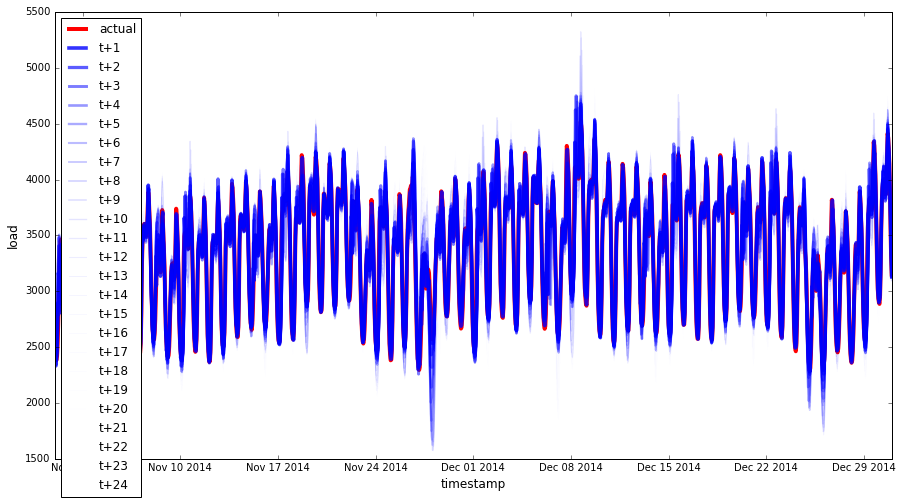

In [24]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()